In [1]:
from datetime import datetime
from MetaTrader5 import *
MT5Initialize()
MT5WaitForTerminal()

print(MT5TerminalInfo())
print(MT5Version())

[2, 'MetaQuotes-Demo', '21592194']
[500, 2233, '28 Nov 2019']


In [2]:
rates = MT5CopyRatesRange("EURUSD", MT5_TIMEFRAME_D1, datetime(2000,1,1), datetime(2019,11,28))

In [3]:
import pandas as pd
d = pd.DataFrame(list(rates),
                           columns=['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume'])

In [4]:
d['median']=(d['high']+d['low'])/2
d['delta'] = d['high'].diff(1).fillna(0)

In [5]:
d

,time,open,high,low,close,tick_volume,spread,real_volume,median,delta
0,2000-01-03,1.00730,1.02780,1.00540,1.02460,6642,50,0,1.016600,0.00000
1,2000-01-04,1.02430,1.03400,1.02130,1.02920,7339,50,0,1.027650,0.00620
2,2000-01-05,1.02930,1.04020,1.02840,1.03260,6570,50,0,1.034300,0.00620
3,2000-01-06,1.03250,1.04150,1.02720,1.03300,7223,50,0,1.034350,0.00130
4,2000-01-07,1.03290,1.03320,1.02600,1.02980,5689,50,0,1.029600,-0.00830
...,...,...,...,...,...,...,...,...,...,...
5171,2019-11-21,1.10723,1.10969,1.10521,1.10581,31829,1,0,1.107450,0.00156
5172,2019-11-22,1.10580,1.10875,1.10144,1.10182,32645,1,0,1.105095,-0.00094
5173,2019-11-25,1.10151,1.10320,1.10035,1.10126,27995,1,0,1.101775,-0.00555
5174,2019-11-26,1.10129,1.10255,1.10072,1.10194,28638,1,0,1.101635,-0.00065


<IPython.core.display.Javascript object>


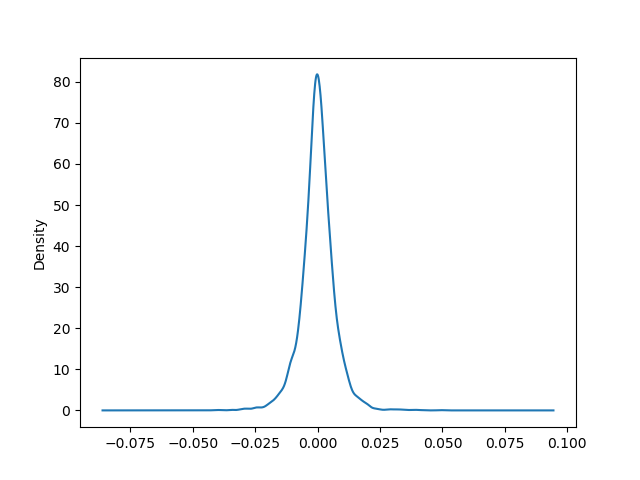

In [7]:
%matplotlib nbagg
d['delta'].plot.kde()

Мы получили распределение Коши. Дальше этот факт будет учитываться.